In [1]:
import os
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from pandas import read_csv
sns.set_theme(style='white', context='notebook', font_scale=1.33)

## Section 1: Parameter Comparison

In [2]:
df1 = read_csv(os.path.join('stan_results','study03','2pl_summary.tsv'), sep='\t', index_col='name')
df2 = read_csv(os.path.join('stan_results','study03','3pl_fixed_summary.tsv'), sep='\t', index_col='name')
df3 = read_csv(os.path.join('stan_results','study03','3pl_summary.tsv'), sep='\t', index_col='name')

#### 1.1 Subject abilities

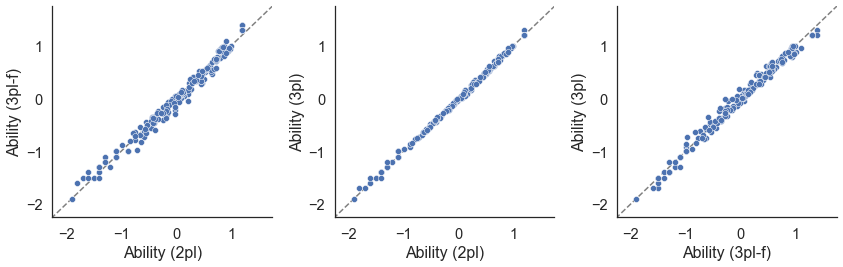

In [3]:
## Initialize canvas.
fig, axes = plt.subplots(1,3,figsize=(12,4))

## Plot comparison 1.
sns.scatterplot(
    x=df1.T.filter(regex='theta').T['Mean'],
    y=df2.T.filter(regex='theta').T['Mean'],
    ax=axes[0]
)

## Plot comparison 2.
sns.scatterplot(
    x=df1.T.filter(regex='theta').T['Mean'],
    y=df3.T.filter(regex='theta').T['Mean'],
    ax=axes[1]
)

## Plot comparison 3.
sns.scatterplot(
    x=df2.T.filter(regex='theta').T['Mean'],
    y=df3.T.filter(regex='theta').T['Mean'],
    ax=axes[2]
)

## Add details.
for ax in axes: ax.plot([-5,5],[-5,5],color='0.5',linestyle='--',zorder=-1)
axes[0].set(xlim=(-2.25,1.75), ylim=(-2.25,1.75), xlabel='Ability (2pl)', ylabel='Ability (3pl-f)')
axes[1].set(xlim=(-2.25,1.75), ylim=(-2.25,1.75), xlabel='Ability (2pl)', ylabel='Ability (3pl)')
axes[2].set(xlim=(-2.25,1.75), ylim=(-2.25,1.75), xlabel='Ability (3pl-f)', ylabel='Ability (3pl)')

sns.despine()
plt.tight_layout()

#### 1.2 Item difficulties

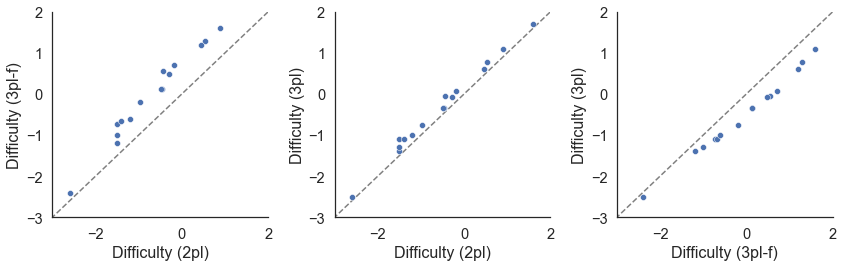

In [4]:
## Initialize canvas.
fig, axes = plt.subplots(1,3,figsize=(12,4))

## Plot comparison 1.
sns.scatterplot(
    x=df1.T.filter(regex='beta').T['Mean'],
    y=df2.T.filter(regex='beta').T['Mean'],
    ax=axes[0]
)

## Plot comparison 2.
sns.scatterplot(
    x=df1.T.filter(regex='beta').T['Mean'],
    y=df3.T.filter(regex='beta').T['Mean'],
    ax=axes[1]
)

## Plot comparison 3.
sns.scatterplot(
    x=df2.T.filter(regex='beta').T['Mean'],
    y=df3.T.filter(regex='beta').T['Mean'],
    ax=axes[2]
)

## Add details.
for ax in axes: ax.plot([-5,5],[-5,5],color='0.5',linestyle='--',zorder=-1)
axes[0].set(xlim=(-3,2), ylim=(-3,2), xlabel='Difficulty (2pl)', ylabel='Difficulty (3pl-f)')
axes[1].set(xlim=(-3,2), ylim=(-3,2), xlabel='Difficulty (2pl)', ylabel='Difficulty (3pl)')
axes[2].set(xlim=(-3,2), ylim=(-3,2), xlabel='Difficulty (3pl-f)', ylabel='Difficulty (3pl)')

sns.despine()
plt.tight_layout()

#### 1.3 Item discriminations

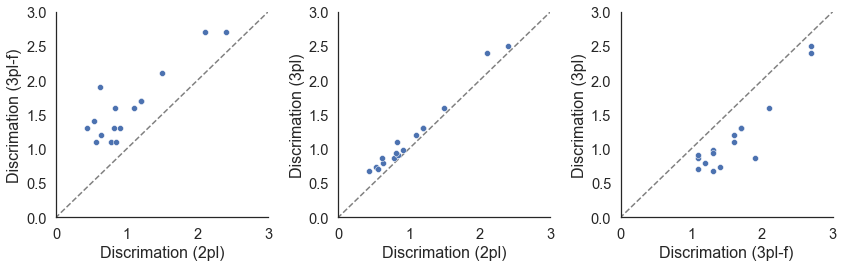

In [5]:
## Initialize canvas.
fig, axes = plt.subplots(1,3,figsize=(12,4))

## Plot comparison 1.
sns.scatterplot(
    x=df1.T.filter(regex='alpha').T['Mean'],
    y=df2.T.filter(regex='alpha').T['Mean'],
    ax=axes[0]
)

## Plot comparison 2.
sns.scatterplot(
    x=df1.T.filter(regex='alpha').T['Mean'],
    y=df3.T.filter(regex='alpha').T['Mean'],
    ax=axes[1]
)

## Plot comparison 3.
sns.scatterplot(
    x=df2.T.filter(regex='alpha').T['Mean'],
    y=df3.T.filter(regex='alpha').T['Mean'],
    ax=axes[2]
)

## Add details.
for ax in axes: ax.plot([-5,5],[-5,5],color='0.5',linestyle='--',zorder=-1)
axes[0].set(xlim=(0,3), ylim=(0,3), xlabel='Discrimation (2pl)', ylabel='Discrimation (3pl-f)')
axes[1].set(xlim=(0,3), ylim=(0,3), xlabel='Discrimation (2pl)', ylabel='Discrimation (3pl)')
axes[2].set(xlim=(0,3), ylim=(0,3), xlabel='Discrimation (3pl-f)', ylabel='Discrimation (3pl)')

sns.despine()
plt.tight_layout()

#### 1.4 Parameter correlations

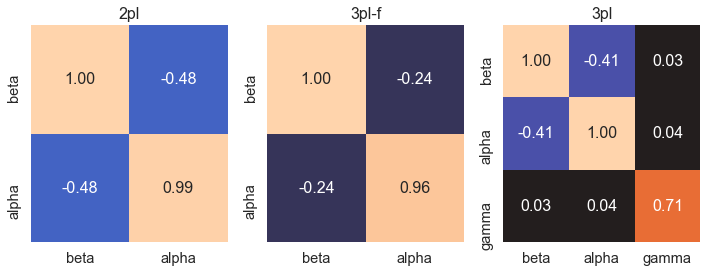

In [6]:
## Initialize canvas.
fig, axes = plt.subplots(1,3,figsize=(12,4))

## Plot model 1.
L = df1.T.filter(regex='L').T['50%'].values.reshape(2,2)
sns.heatmap(L @ L.T, vmin=-1, vmax=1, center=0, cbar=False, annot=True, fmt='0.2f', ax=axes[0],
            xticklabels=['beta','alpha'], yticklabels=['beta','alpha'])
axes[0].set_title('2pl')

## Plot model 2.
L = df2.T.filter(regex='L').T['50%'].values.reshape(2,2)
sns.heatmap(L @ L.T, vmin=-1, vmax=1, center=0, cbar=False, annot=True, fmt='0.2f', ax=axes[1],
            xticklabels=['beta','alpha'], yticklabels=['beta','alpha'])
axes[1].set_title('3pl-f')

## Plot model 3.
L = df3.T.filter(regex='L').T['50%'].values.reshape(3,3)
sns.heatmap(L @ L.T, vmin=-1, vmax=1, center=0, cbar=False, annot=True, fmt='0.2f', ax=axes[2],
            xticklabels=['beta','alpha','gamma'], yticklabels=['beta','alpha','gamma'])
axes[2].set_title('3pl');

## Section 2: Posterior Predictive Check

In [7]:
df1 = read_csv(os.path.join('stan_results','study03','2pl_ppc.tsv'), sep='\t')
df2 = read_csv(os.path.join('stan_results','study03','3pl_fixed_ppc.tsv'), sep='\t')
df3 = read_csv(os.path.join('stan_results','study03','3pl_ppc.tsv'), sep='\t')

#### 2.1 Subject accuracy 

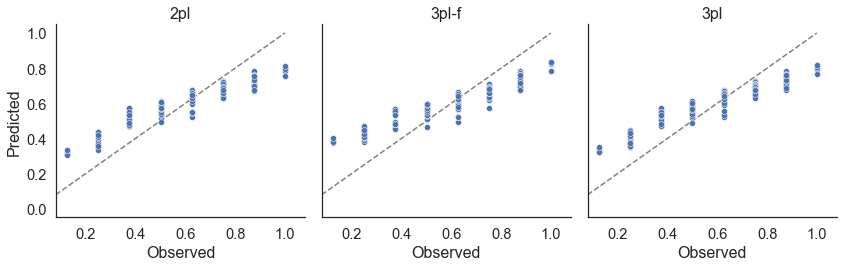

In [8]:
## Initialize canvas.
fig, axes = plt.subplots(1,3,figsize=(12,4),sharex=True,sharey=True)
agg = {'accuracy':'mean', 'Y_hat':'mean'}
    
## Main loop.
for ax, df, title in zip(axes, [df1, df2, df3], ['2pl','3pl-f','3pl']):
    
    ## Compute mean within subjects.
    gb = df.groupby('subject').agg(agg)
    
    ## Plot posterior predictive check.
    sns.scatterplot(x='accuracy', y='Y_hat', data=gb, color='#4c72b0', ax=ax)
    ax.plot([0,1],[0,1],color='0.5',linestyle='--',zorder=-1)
    
    ## Add detail.
    ax.set(xlim=(0.08,1.08), xlabel='Observed', title=title)
    if title == '2pl': ax.set_ylabel('Predicted')
    
sns.despine()
plt.tight_layout()

#### 2.2 Item accuracy 

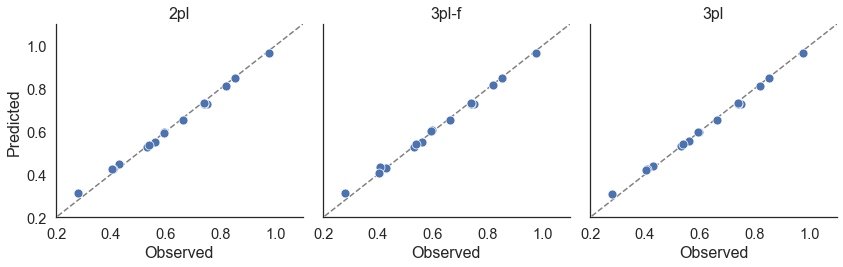

In [9]:
## Initialize canvas.
fig, axes = plt.subplots(1,3,figsize=(12,4),sharex=True,sharey=True)
agg = {'accuracy':'mean', 'Y_hat':'mean'}
    
## Main loop.
for ax, df, title in zip(axes, [df1, df2, df3], ['2pl','3pl-f','3pl']):
    
    ## Compute mean within subjects.
    gb = df.groupby('stimulus').agg(agg)
    
    ## Plot posterior predictive check.
    sns.scatterplot(x='accuracy', y='Y_hat', data=gb, color='#4c72b0', s=80, ax=ax)
    ax.plot([0,2],[0,2],color='0.5',linestyle='--',zorder=-1)
    
    ## Add detail.
    ax.set(xlim=(0.2,1.1), ylim=(0.2,1.1), xlabel='Observed', title=title)
    if title == '2pl': ax.set_ylabel('Predicted')
    
sns.despine()
plt.tight_layout()

#### 2.3 Model comparison

In [10]:
## Main loop.
for df, title in zip([df1, df2, df3], ['2pl','3pl-f','3pl']):
    print('%s:\t%0.2f' %(title, df.WAIC.sum()))

2pl:	-812.60
3pl-f:	-813.41
3pl:	-814.07
